In [1]:
# General imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
# Image processing imports
from scipy import misc
from skimage.transform import resize
from skimage.filters import threshold_otsu

In [3]:
# Machine learning imports
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Initial test - RNN + single image

Train an RNN to indentify segementation training on a single image.  Target segementations are generated with the pixel sum heuristic; images are resized to 100 pixel height, a column that sums to < 10 is considered a valid segmentation for training.

In [4]:
dataPath = '/Users/dwright/dev/gym-zooniverse/gym_zooniverse/envs/assets/' # path to image data

In [5]:
# load the example image for this test
image = misc.imread(os.path.join(dataPath+'a01/a01-000u/a01-000u-00-01.png'))
h, w = image.shape
image = resize(image, (100, w)) # resize to 100 pixel height, preserving original width
thresh = threshold_otsu(image)  # calculate threshold to cast the image as a binary
image = np.asarray(image < thresh, dtype='int') # cast to binary image

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


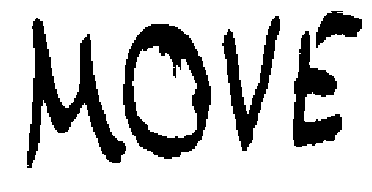

In [6]:
# visualise the image
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

In [7]:
# generate the valid segmentations
y = np.zeros((image.shape[1]))
for i in range(image.shape[1]):
  y[i] += np.sum(image[:,i]) <= 10

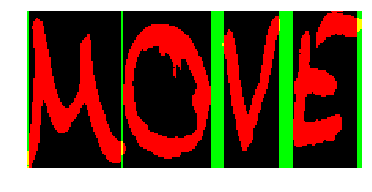

In [8]:
# plot the segmentations
img = np.zeros((image.shape[0], image.shape[1], 3))
img[:,:,0] += image
for i in range(len(y)):
  img[:,i,1] += y[i]
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
# build a RNN to train on this image
model = Sequential()
model.add(LSTM(256, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [10]:
# train the model
model.fit(image.T[:,np.newaxis,:], np_utils.to_categorical(y, 2), epochs=5, batch_size=1, verbose=1)

Epoch 1/5
213/213 [==============================] - 3s - loss: 0.1487 - acc: 0.9155       

In [11]:
# get the predicted segmentations
pred = np.argmax(model.predict(image.T[:,np.newaxis,:]), axis=1)

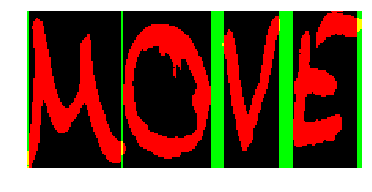

In [12]:
# visualise the predicted segmentations
img = np.zeros((image.shape[0], image.shape[1], 3))
img[:,:,0] += image
for i in range(len(pred)):
  img[:,i,1] += pred[i]
plt.imshow(img)
plt.axis('off')
plt.show()

# Initial test - Evolution Strategy + single image

In this case rather than using heuristics to determine a set of valid segmentation columns and trian using back prop., we will use human input and evolution strategies to train the RNN.

In [27]:
# build a model similar to above, but smaller for the time being.
model = Sequential()
model.add(LSTM(8, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 8)                 3488      
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 18        
Total params: 3,506.0
Trainable params: 3,506
Non-trainable params: 0.0
_________________________________________________________________


In [28]:
# get the weights from this network (it is currently only randomly initialised)
w = model.get_weights()

In [156]:
# define some parameters for the evolution strategy
npop = 10      # population size
sigma = 0.1    # noise standard deviation
alpha = 0.001  # learning rate

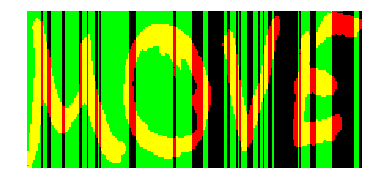

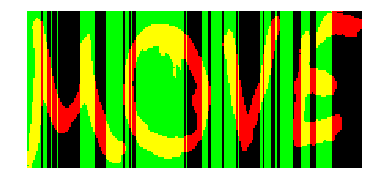

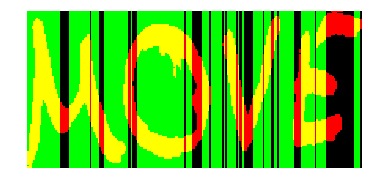

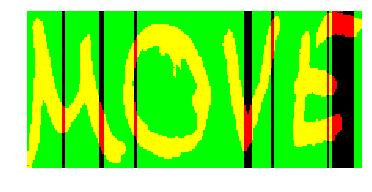

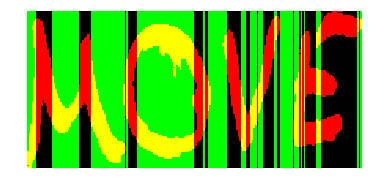

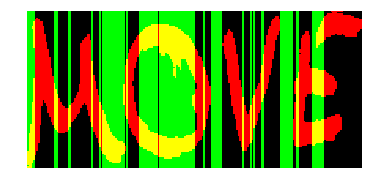

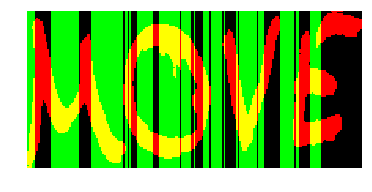

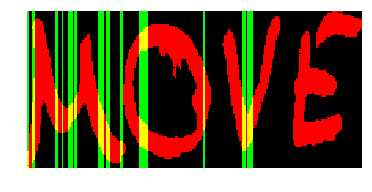

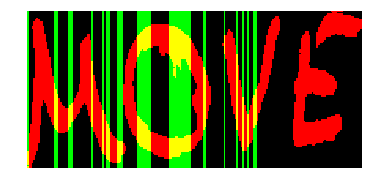

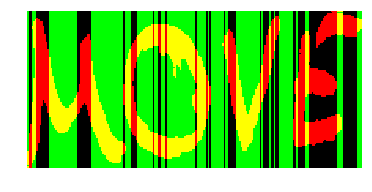

In [30]:
# perturb the weights of the RNN and make a prediction
for i in range(npop):
  # clone the original model
  model_copy = Sequential()
  model_copy.add(LSTM(8, input_shape=(None, 100)))
  model_copy.add(Dense(2, activation='softmax'))
  model_copy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  w_try = w[:]
  for j in range(len(w)):
    try:
      w_try[j] += sigma * np.random.randn(w[j].shape[0], w[j].shape[1])
    except IndexError:
      w_try[j] += sigma * np.random.randn(w[j].shape[0])
  model_copy.set_weights(w_try)
  pred = np.argmax(model_copy.predict(image.T[:,np.newaxis,:]), axis=1)
  img = np.zeros((image.shape[0], image.shape[1], 3))
  img[:,:,0] += image
  for i in range(len(pred)):
    img[:,i,1] += pred[i]
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# Image snippets test.
For many of the images above it could be difficult to determine which are better than taking into account the entire image.
Instead try to break the image up into smaller snippets of say 20 pixels wide.

In [139]:
def window_transform_series(series, windowSize):
  # containers for input/output pairs
  X = []
  y = []
  n = series.shape[1]
  for i in range(windowSize, n-windowSize):
    X.append(series[:,i-windowSize:i+windowSize])
    y.append(np.sum(series[:,i]) < 10)
  if y == []:
    return None, None
  X = np.asarray(X)
  y = np.asarray(y)
  return X, y

In [140]:
X, y = window_transform_series(image, 20)

In [141]:
print(X.shape, y.shape)

(173, 100, 40) (173,)


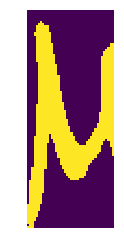

In [142]:
plt.imshow(X[0])
plt.axis('off')
plt.show()

In [143]:
# shuffle the snippets
m = len(X)
order = np.random.permutation(m)
X = np.reshape(X[order], (X.shape[0], X.shape[2], X.shape[1]))
y = y[order]
print(y)

[False False False False False False False False False  True False  True
 False  True False False False False False False False False False False
 False False False False False  True False False False  True  True False
 False False False False False False False False False False False False
  True False False False False False False  True False False False False
 False False False False False  True False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False  True
 False False  True  True False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False  True False  True False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [144]:
# build a RNN to train on these 
model = Sequential()
model.add(LSTM(256, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [145]:
model.fit(X, np_utils.to_categorical(y, 2), epochs=50, batch_size=128, verbose=1, shuffle=False)

Epoch 1/50
173/173 [==============================] - 10s - loss: 0.5834 - acc: 0.8960    
Epoch 2/50
173/173 [==============================] - 3s - loss: 0.3051 - acc: 0.8960     
Epoch 3/50
173/173 [==============================] - 2s - loss: 0.3663 - acc: 0.8960     
Epoch 4/50
173/173 [==============================] - 3s - loss: 0.3078 - acc: 0.8960     
Epoch 5/50
173/173 [==============================] - 2s - loss: 0.2976 - acc: 0.8960     
Epoch 6/50
173/173 [==============================] - 2s - loss: 0.2885 - acc: 0.8960     

In [ ]:
X, _ = window_transform_series(image, 20)
X = np.reshape(X, (X.shape[0], X.shape[2], X.shape[1]))
pred = np.argmax(model.predict(X), axis=1)
print(pred)

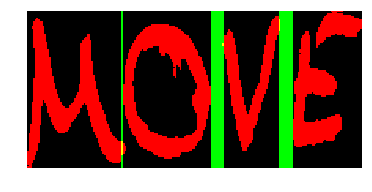

In [150]:
# visualise the predicted segmentations
img = np.zeros((image.shape[0], image.shape[1], 3))
img[:,:,0] += image
for i in range(20,len(pred)):
  img[:,i+20,1] += pred[i]
plt.imshow(img)
plt.axis('off')
plt.show()

# Image snippets +evolution strategy

In [183]:
# build a model similar to above, but smaller for the time being.
model = Sequential()
model.add(LSTM(256, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 256)               365568    
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 514       
Total params: 366,082.0
Trainable params: 366,082
Non-trainable params: 0.0
_________________________________________________________________


In [184]:
# get the weights from this network (it is currently only randomly initialised)
w = model.get_weights()

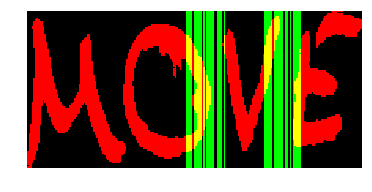

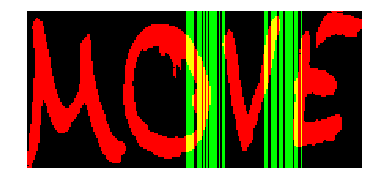

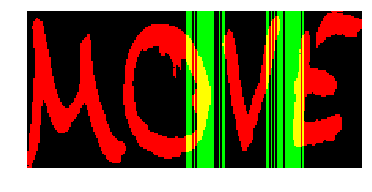

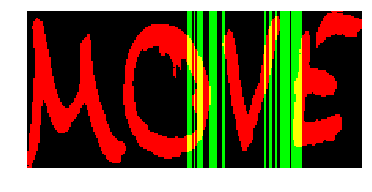

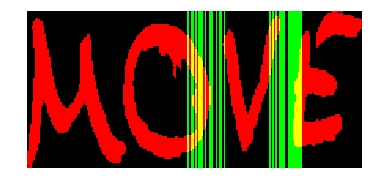

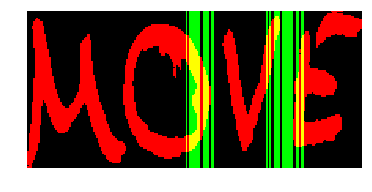

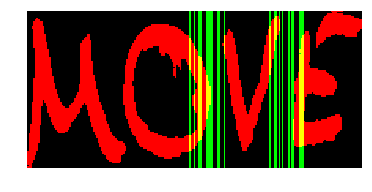

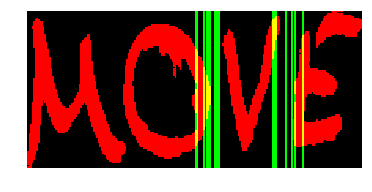

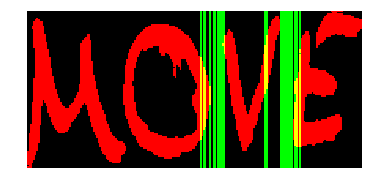

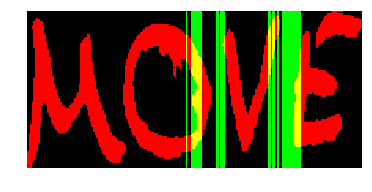

In [186]:
# perturb the weights of the RNN and make a prediction
for i in range(npop):
  # clone the original model
  model_copy = Sequential()
  model_copy.add(LSTM(256, input_shape=(None, 100)))
  model_copy.add(Dense(2, activation='softmax'))
  model_copy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  w_try = w[:]
  for j in range(len(w)):
    try:
      w_try[j] += sigma * np.random.randn(w[j].shape[0], w[j].shape[1])
    except IndexError:
      w_try[j] += sigma * np.random.randn(w[j].shape[0])
  model_copy.set_weights(w_try)
  #pred = np.argmax(model_copy.predict(X), axis=1)
  img = np.zeros((image.shape[0], image.shape[1], 3))
  img[:,:,0] += image
  for i in range(100, 125):
    img[:,i+1,1] += np.argmax(model_copy.predict(image[:,i-40:i].T[np.newaxis]), axis=1)
  for i in range(150, 175):
    img[:,i+1,1] += np.argmax(model_copy.predict(image[:,i-40:i].T[np.newaxis]), axis=1)
  plt.imshow(img)
  plt.axis('off')
  plt.show()